Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
count of dataset:  160
count of train images is:  128
count of validation images is:  16
count of test images is:  16
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
       UnetEncoder-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
      BatchNorm2d-10        [-1, 128, 112, 112

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:276: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[21/50][0/16]	Loss: 0.0669	Loss_Val: 0.2435	Dice: 0.9641	Dice_Val: 0.8553	Jaccard: 0.9309	Jaccard_Val: 0.7699	Learning Rate: 0.006220
[21/50][2/16]	Loss: 0.0740	Loss_Val: 0.0902	Dice: 0.9535	Dice_Val: 0.9416	Jaccard: 0.9116	Jaccard_Val: 0.8929	Learning Rate: 0.006220
[21/50][4/16]	Loss: 0.0641	Loss_Val: 0.0599	Dice: 0.9646	Dice_Val: 0.9650	Jaccard: 0.9320	Jaccard_Val: 0.9330	Learning Rate: 0.006220
[21/50][6/16]	Loss: 0.0510	Loss_Val: 0.0604	Dice: 0.9707	Dice_Val: 0.9683	Jaccard: 0.9432	Jaccard_Val: 0.9391	Learning Rate: 0.006220
[21/50][8/16]	Loss: 0.0564	Loss_Val: 0.0806	Dice: 0.9687	Dice_Val: 0.9561	Jaccard: 0.9396	Jaccard_Val: 0.9171	Learning Rate: 0.006220
[21/50][10/16]	Loss: 0.0562	Loss_Val: 0.0604	Dice: 0.9685	Dice_Val: 0.9668	Jaccard: 0.9394	Jaccard_Val: 0.9365	Learning Rate: 0.006220
[21/50][12/16]	Loss: 0.0652	Loss_Val: 0.0622	Dice: 0.9686	Dice_Val: 0.9635	Jaccard: 0.9393	Jaccard_Val: 0.9309	Learning Rate: 0.006220
[21/50][14/16]	Loss: 0.0553	Loss_Val: 0.0617	Dice: 0.9707	Di

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:308: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

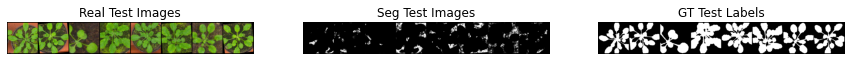

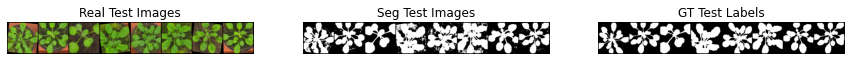

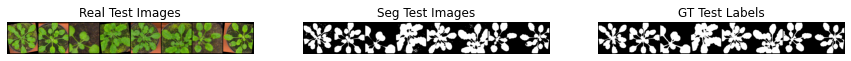

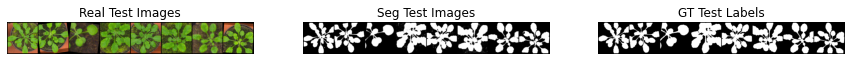

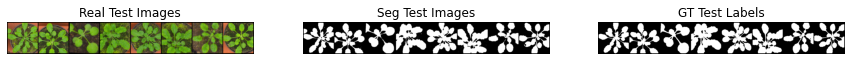

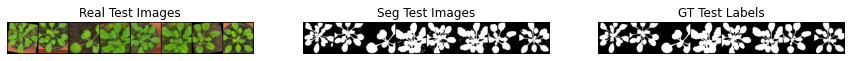

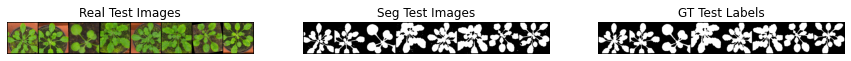

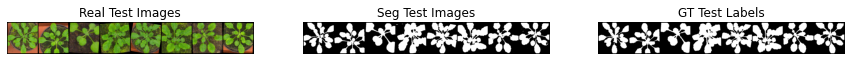

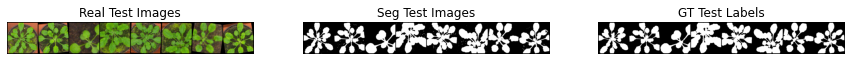

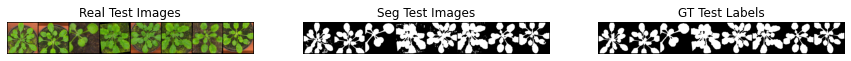

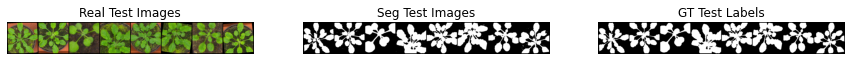

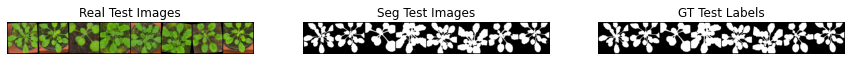

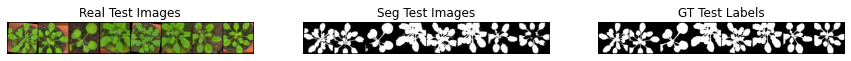

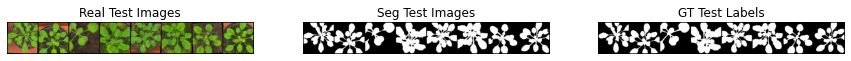

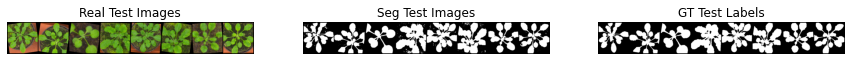

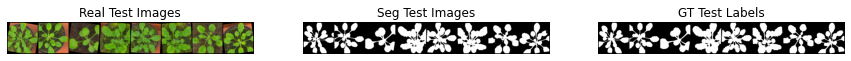

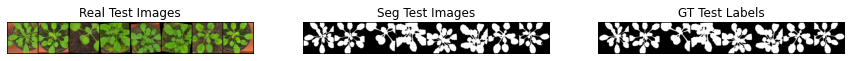

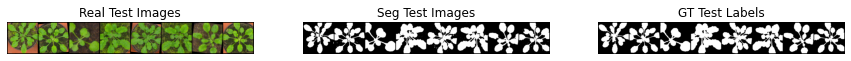

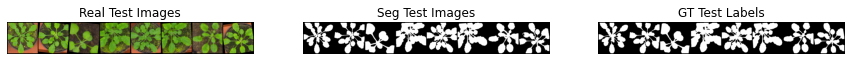

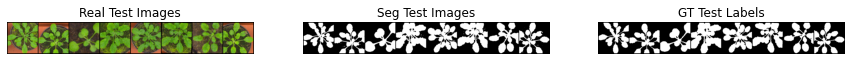

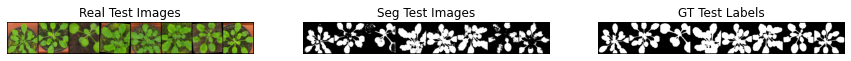

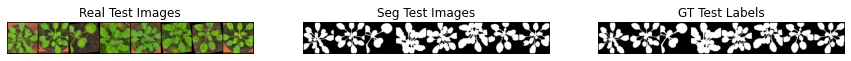

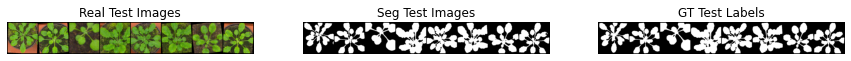

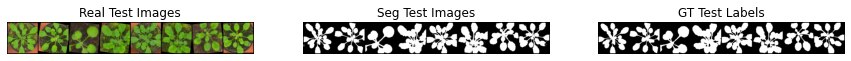

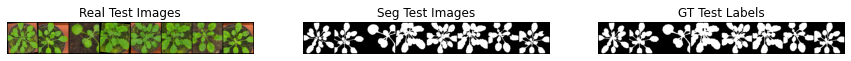

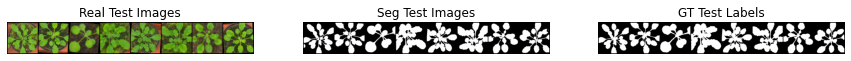

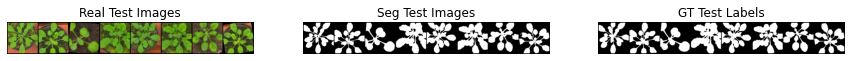

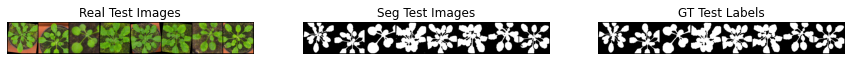

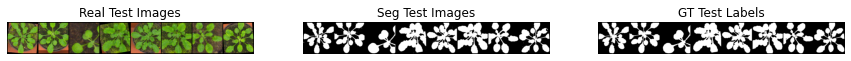

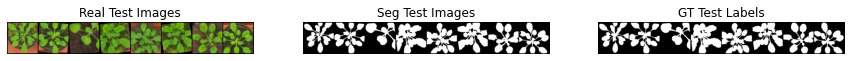

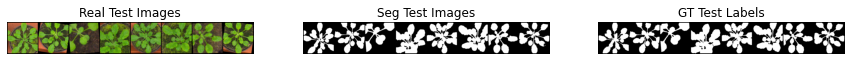

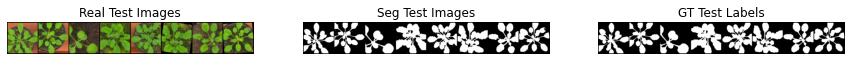

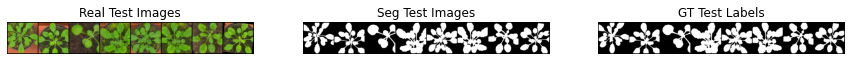

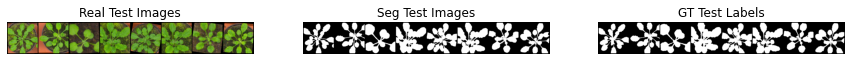

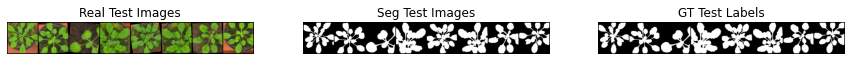

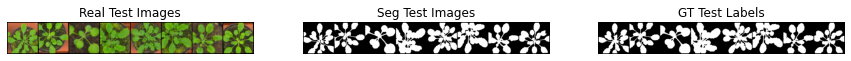

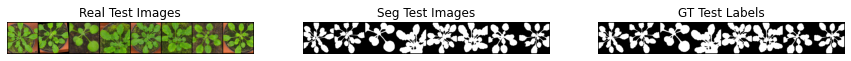

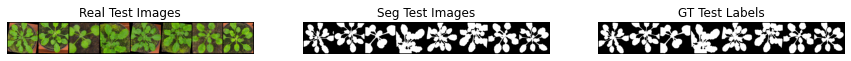

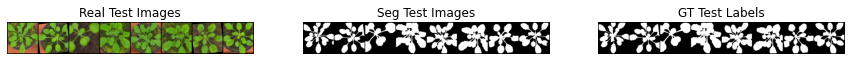

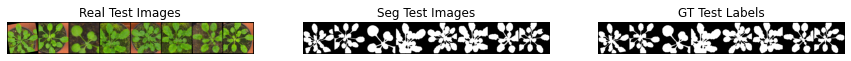

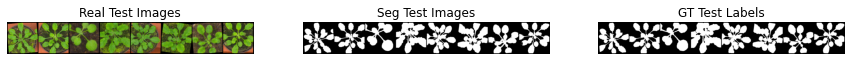

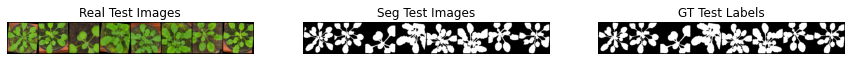

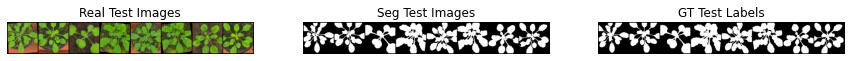

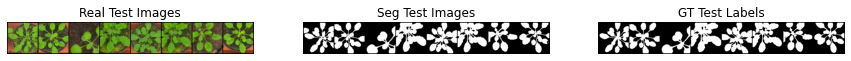

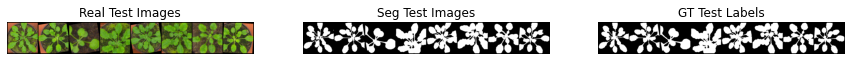

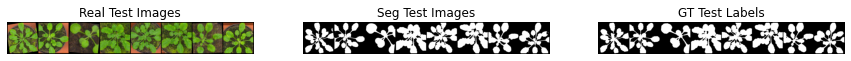

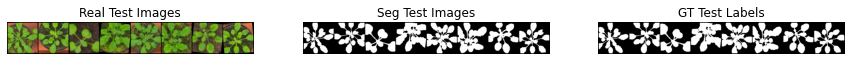

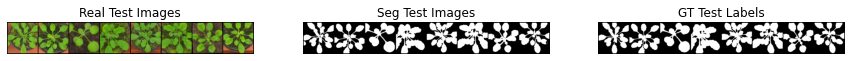

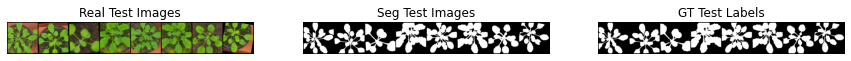

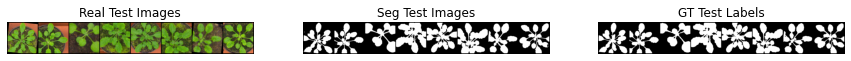

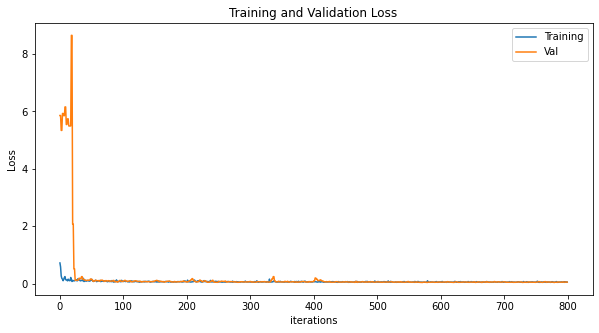

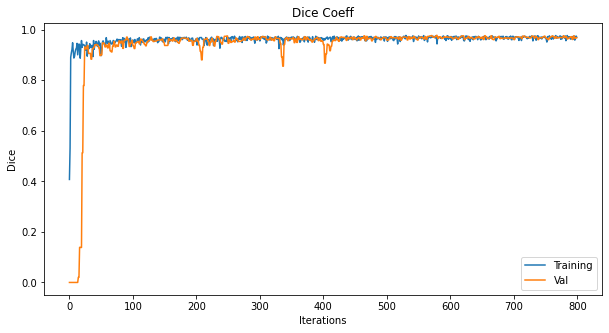

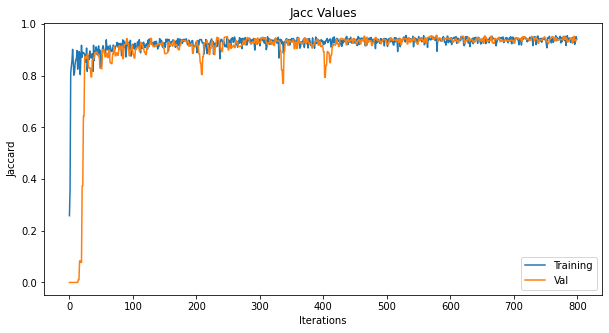

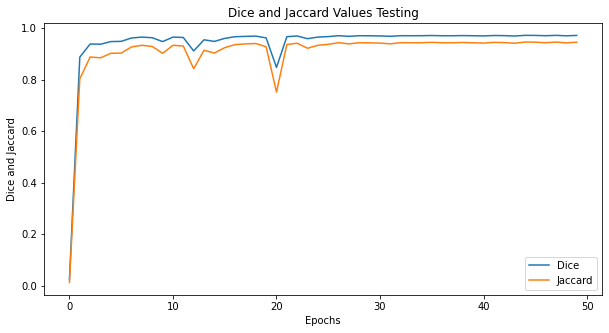

In [3]:
from __future__ import print_function
# %matplotlib inline
import argparse
import sys
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import matplotlib.animation as animation
# from IPython.display import HTML
from torch.optim import lr_scheduler
import datetime
from shutil import copyfile
import glob

import dataset_utils
import Unet
import Unet_smaller
from tools import *

from google.colab import drive
drive.mount('/content/gdrive')

# Set random seed for reproducibility
# manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

# Root directory for dataset
Images = "/content/gdrive/My Drive/Signify_project/images"
Labels="/content/gdrive/My Drive/Signify_project/labels"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8


# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.01
target_lr=0.001


# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#Location to store your new checkpoints
# check_points_location='/content/gdrive/My Drive/Signify_project/Results'

#Location to store your new checkpoints, and all the segmented and real images
dir_name = '/content/gdrive/My Drive/Signify_project/Results/'
if not (os.path.exists(dir_name)):
   os.mkdir(dir_name)

# Copy the current script to the directory
src_script = sys.argv[0]
dst_script = dir_name + '/script.py'
copyfile(src_script,dst_script)




# Functon to load the data and return the DataLoaders					
def load_data(Images_dir, Labels_dir):

	folder_data = glob.glob(Images_dir +'/*.png')
	folder_mask = glob.glob(Labels_dir +'/*.png')


	len_data = len(folder_data)
	print("count of dataset: ", len_data)

	folder_data.sort()
	folder_mask.sort()
	
  # Shuffle the images in the Image and Label folders simultaneously to maintain one to one correspondence
	c=list(zip(folder_data,folder_mask))
	random.shuffle(c)
	folder_data,folder_mask=zip(*c)
 
  # Split the dataset into training, validation and testing
	split_1 = int(0.8 * len(folder_data))
	split_2 = int(0.9 * len(folder_data))

	train_image_paths = folder_data[:split_1]
	print("count of train images is: ", len(train_image_paths))

	valid_image_paths = folder_data[split_1:split_2]
	print("count of validation images is: ", len(valid_image_paths))

	test_image_paths = folder_data[split_2:]
	print("count of test images is: ", len(test_image_paths))

	train_mask_paths = folder_mask[:split_1]

	valid_mask_paths = folder_mask[split_1:split_2]

	test_mask_paths = folder_mask[split_2:]


	train_dataset = dataset_utils.MyDataset(train_image_paths, train_mask_paths)
	train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

	valid_dataset = dataset_utils.MyDataset(valid_image_paths, valid_mask_paths)
	valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

	test_dataset = dataset_utils.MyDataset(test_image_paths, test_mask_paths)
	test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
	return train_loader,valid_loader,test_loader

# Function to evaluate on test data
def evaluate(tst_loader):
  dice_loss_test_sum=[]
  jacc_loss_test_sum=[]
  dice_test_sum=[]
  jacc_test_sum=[]
  model.eval()
  for iterator,data_test_iter in enumerate (tst_loader):
    images_test,labels_test=data_test_iter
    images_test = images_test.to(device)
    labels_test=labels_test.to(device)
    with torch.no_grad():
     outputs_test=model(images_test.detach())
     dice_loss_test,jacc_loss_test,jacc_test,dice_test=dice_loss(outputs_test,labels_test)
    dice_loss_test_sum.append(dice_loss_test.item())
    jacc_loss_test_sum.append(jacc_loss_test.item())
    jacc_test_sum.append(jacc_test.item())
    dice_test_sum.append(dice_test.item())
  dice_loss_test_avg=sum(dice_loss_test_sum)/len(dice_loss_test_sum)
  jacc_loss_test_avg=sum(jacc_loss_test_sum)/len(jacc_loss_test_sum)
  dice_test_avg=sum(dice_test_sum)/len(dice_test_sum)
  jacc_test_avg=sum(jacc_test_sum)/len(jacc_test_sum)
  return outputs_test,images_test,labels_test,dice_loss_test_avg,jacc_loss_test_avg,dice_test_avg,jacc_test_avg


def adjust_learning_rate(optimizer, init_lr, target_lr, epoch, factor, every):
  lrd = (init_lr-target_lr) / every
  old_lr = optimizer.param_groups[0]['lr']
   # linearly decaying lr
  lr = old_lr - lrd
  if lr < 0: lr = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Prepare the DataLoaders
tr_loader,vl_loader,tst_loader=load_data(Images,Labels)

# Model instantiation and printing the modelsummary
model=Unet_smaller.UNet(1).to(device)
summary(model,(3,224,224))

# BCE loss and Adam optimizer
criterion = nn.BCELoss()
optimizer= optim.Adam(model.parameters(), lr=lr)

#Uncomment the below lines for using SGD optimizer with other learning rate schedulers
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.00005, momentum=0.90)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.6)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
	model = nn.DataParallel(model, list(range(ngpu)))

# Print the model
print(model)


# Training Loop

# Lists to keep track of progress
img_list = []
tr_losses = []
val_losses = []
tr_dice=[]
tr_jacc=[]
val_dice=[]
val_jacc=[]
test_dice=[]
test_jacc=[]
D_losses = []
iters = 0
lr_list=[]

print("Starting Training Loop...")

for epoch in range(num_epochs):  # loop over the dataset multiple times

	for i, data in enumerate(tr_loader, 0):
		# get the inputs; data is a list of [inputs, labels]
		inputs, labels = data
		inputs=inputs.to(device)
		labels=labels.to(device)
		data_val_iter=iter(vl_loader)
		images_val, labels_val = data_val_iter.next()
		images_val=images_val.to(device)
		labels_val=labels_val.to(device)
		
		
		# zero the parameter gradients
		optimizer.zero_grad()

		# forward + backward + optimize
		outputs=model(inputs)
		bce_loss_tr = criterion(outputs, labels)
		dice_loss_tr,jacc_loss_tr,jacc_tr,dice_tr=dice_loss(outputs,labels)
		loss=loss_function(bce_loss=bce_loss_tr,dice_loss=jacc_loss_tr,bce_weight=0.5)
		loss.backward()
		optimizer.step()
		lr_1 = optimizer.param_groups[0]['lr']
		lr_list.append(lr_1)
    


		# Output training stats
		if i % 2 == 0:
			model.eval()
			with torch.no_grad():
				outputs_val = model(images_val.detach())
				bce_loss_val=criterion(outputs_val,labels_val)
				dice_loss_val,jacc_loss_val,jacc_val,dice_val=dice_loss(outputs_val,labels_val)
				loss_val=loss_function(bce_loss=bce_loss_val,dice_loss=jacc_loss_val,bce_weight=0.5)
			model.train()
			print('[%d/%d][%d/%d]\tLoss: %.4f\tLoss_Val: %.4f\tDice: %.4f\tDice_Val: %.4f\tJaccard: %.4f\tJaccard_Val: %.4f\tLearning Rate: %f'
				  % (epoch, num_epochs, i, len(tr_loader),
					 loss.item(),loss_val.item(),dice_tr.item(),dice_val.item(),jacc_tr.item(),jacc_val.item(),lr_1))

		# Save Losses and performance metrics for plotting later
		tr_losses.append(loss.item())
		val_losses.append(loss_val.item())
		tr_dice.append(dice_tr.item())
		val_dice.append(dice_val.item())
		tr_jacc.append(jacc_tr.item())
		val_jacc.append(jacc_val.item())

		iters += 1
	outputs_test,images_test,labels_test,dice_loss_test_avg,jacc_loss_test_avg,dice_test_avg,jacc_test_avg=evaluate(tst_loader)
	model.train()

  

	if (epoch % 4==0):
		print('[%d/%d][%d/%d]\tDice_Test: %.4f\tJaccard_Test: %.4f'
				  % (epoch, num_epochs, i, len(tr_loader),
					 dice_test_avg,jacc_test_avg))
	test_dice.append(dice_test_avg)
	test_jacc.append(jacc_test_avg)
	# test_dice.append(dice_test.item())
  # test_jacc.append(jacc_test.item())

	

  # Display the Input Test Images
	plt.figure(figsize=(15, 15))
	plt.subplot(1, 3, 1)
	plt.axis("off")
	plt.title("Real Test Images")
	with torch.no_grad():
		plt.imshow(np.transpose(vutils.make_grid(images_test.to(device), padding=5).cpu(), (1, 2, 0)))
	

	# Display the Segmented Test Images
	plt.subplot(1, 3, 2)
	plt.axis("off")
	plt.title("Seg Test Images")
	with torch.no_grad():
		plt.imshow(np.transpose(vutils.make_grid(outputs_test.to(device), padding=5).cpu(), (1, 2, 0)))	#plt.show()
	
  # Display the Ground Truth Test Images
	plt.subplot(1, 3, 3)
	plt.axis("off")
	plt.title("GT Test Labels")
	with torch.no_grad():
		plt.imshow(np.transpose(vutils.make_grid(labels_test.to(device), padding=5).cpu(), (1, 2, 0)))
	plt.savefig('%s/Real_and_Segmented_Images_Testing_%d.png' % (dir_name, epoch))

  # Saving the model every 4 epochs
	if epoch % 4 == 0:
		torch.save(model.state_dict(), '%s/Unet_epoch_%d.pth' % (dir_name, epoch))

	# Learning rate update for Linear scheduler. Comment this line and uncomment the next line when using the Step or Exponential scheduler
	adjust_learning_rate(optimizer,lr,target_lr,epoch,None,num_epochs)
	# scheduler.step()

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(tr_losses, label="Training")
plt.plot(val_losses,label="Val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('%s/Losses.png' % (dir_name))

# Plotting Dice Coeff for training and validation images in a batch  
plt.figure(figsize=(10, 5))
plt.title("Dice Coeff")
plt.plot(tr_dice, label="Training")
plt.plot(val_dice,label="Val")
plt.xlabel("Iterations")
plt.ylabel("Dice")
plt.legend()
plt.savefig('%s/Dice_train_Val.png' % (dir_name))

# Plotting Jaccard Index for training and validation images in a batch 
plt.figure(figsize=(10, 5))
plt.title("Jacc Values")
plt.plot(tr_jacc, label="Training")
plt.plot(val_jacc,label="Val")
plt.xlabel("Iterations")
plt.ylabel("Jaccard")
plt.legend()
plt.savefig('%s/Jaccard_train_Val.png' % (dir_name))

# Plotting Dice Coeff and Jaccard Index for all the test images 
plt.figure(figsize=(10, 5))
plt.title("Dice and Jaccard Values Testing")
plt.plot(test_dice, label="Dice")
plt.plot(test_jacc,label="Jaccard")
plt.xlabel("Epochs")
plt.ylabel("Dice and Jaccard")
plt.legend()
#plt.show()
plt.savefig('%s/Dice_Jaccard_test.png' % (dir_name))



